# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology
## Chapter : Tilted transversally isotropic metrics

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic traveltime tomography. 
The intended use cases are fairly similar to [metrics defined by a Hooke tensor](Seismic.ipynb), which illustrates a closely related model. Under the hood, however, we use a completely different implementation.

**Tilted transversally isotropic models.**
We consider eikonal equations of the following form 
$$
    l(X^2+Y^2,Z^2) + q(X^2+Y^2,Z^2) = 1
$$
where $l$ is a linear form, and $q$ a quadratic form, and where 
$$
    (X,Y,Z) = A \nabla u
$$
for some linear transformation $A$. In dimension two, simply ignore the $Y$ coordinate.

Some algebraic conditions are required on $l$ and $q$ for this equation to make sense. On the other hand, the linear map $A$ is arbitrary.
In the special case where $q=0$, one recovers a Riemannian eikonal equation.

The numerical scheme is based on rewriting this equation as an extremum of a family of Riemannian eikonal equations, in the form
$$
    \max_{t \in [0,1]} \|\nabla u\|_{D(t)} = 1, 
$$
where $D(t)$ depends on the parameters $l$,$q$ and $A$, in addition to $t$. From this point, one can rely on the Eulerian discretization of [Riemannian eikonal equations](../Riemannian.ipynb).

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TTI','FMM'))

In [5]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd.Metrics.Seismic import Hooke,TTI
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Images/TTI'
norm_infinity = ad.Optimization.norm_infinity

In [6]:
import numpy as np
#import scipy.linalg
#from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,lp,Hooke,TTI
    Eikonal,ad,lp,Hooke,TTI = rreload([Eikonal,ad,lp,Hooke,TTI],rootdir="../..")

## 1. Two dimensions

### 1.1 Induced norm

In [49]:
ReloadPackages()

In [38]:
n=5
hfmIn_Constant = Eikonal.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'factoringMethod':'Static',
    'factoringRadius':20,
    'seedRadius':0,
    'order':2
#    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
#                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
#    'exportGeodesicFlow':1,
})
w=1
hfmIn_Constant.SetRect(sides=[[-w,w],[-w,w]],dimx=2*n+1,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() # Horizontal and vertical axis

#metric = Reduced([1.,1],[[0.5,0.1],[0.1,-0.2]]).rotate_by(0.5) #Linear and quadratic part
metric = TTI([1.,2.],[[0.,0.2],[0.2,0.]],vdim=2).rotate_by(0.5)
hfmIn_Constant['metric'] = metric

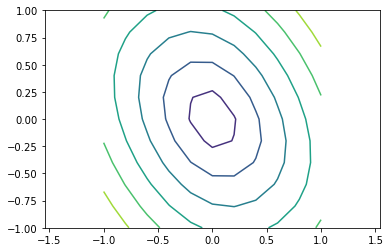

In [30]:
plt.axis('equal')
plt.contour(*X,metric.norm(X))

In [31]:
v=np.array((0.,1.))
grad = metric.gradient(v)
a=metric.inverse_transformation
lvl = metric._dual_level(lp.dot_AV(a,grad))
print(f"v={v},grad={grad},lvl={lvl}")

v=[0. 1.],grad=[0.24019447 0.76738101],lvl=-2.220446049250313e-16


### 1.2 Fast marching method

In [32]:
hfmOut = hfmIn_Constant.Run()

Field verbosity defaults to 1
Fast marching solver completed in 0.002372 s.


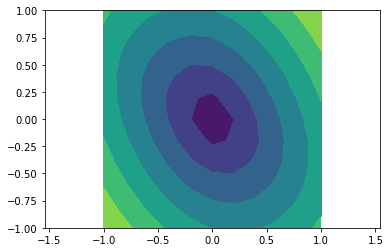

In [33]:
plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

In [34]:
#plt.axis('equal')
#plt.scatter(*hfmOut['spreadedSeeds'].T)
#plt.scatter(0,0)

### 1.3 Conversion to and from a Hooke tensor

In [124]:
ReloadPackages()

In [85]:
from collections import OrderedDict
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%5.3g" % x))

In [130]:
Hooke.olivine().transform(np.array([[1,0,1.5],[0,1,2.],[0,0,1]]).T).apply_transform().hooke

array([[2.54e+03, 2.64e+03,   601, -1.2e+03, -1.14e+03, 2.27e+03],
       [2.64e+03, 5.6e+03, 1.02e+03, -2.29e+03, -1.52e+03, 3.44e+03],
       [  601, 1.02e+03,   235,  -470,  -353,   705],
       [-1.2e+03, -2.29e+03,  -470, 1.00e+03,   705, -1.51e+03],
       [-1.14e+03, -1.52e+03,  -353,   705,   608, -1.22e+03],
       [2.27e+03, 3.44e+03,   705, -1.51e+03, -1.22e+03, 2.66e+03]])

In [121]:
Hooke.olivine().hooke

array([[  324,  66.4,  71.6,     0,     0,     0],
       [ 66.4,   198,  75.6,     0,     0,     0],
       [ 71.6,  75.6,   235,     0,     0,     0],
       [    0,     0,     0,  64.6,     0,     0],
       [    0,     0,     0,     0,  78.7,     0],
       [    0,     0,     0,     0,     0,    79]])

In [115]:
Hooke.olivine().rotate(lp.rotation(2.,[1.,0.,0.])).to_Mandel()

array([[  324,  70.7,  67.3,  2.78,     0,     0],
       [ 70.7,   225,  78.9,  14.1,     0,     0],
       [ 67.3,  78.9,   201,  5.99,     0,     0],
       [ 2.78,  14.1,  5.99,   136,     0,     0],
       [    0,     0,     0,     0,   158, -0.227],
       [    0,     0,     0,     0, -0.227,   158]])

In [97]:
np.linalg.eigvalsh(Hooke.olivine().rotate(lp.rotation(4.,[1.,2.,3.])).to_Mandel())

array([  129,   138,   157,   158,   211,   408])

In [135]:
np.linalg.eigvalsh([[1,1,0],[1,2.,1],[0,1,1]])

array([3.93e-17,     1,     3])

In [139]:
OrderedDict(x=2,y=3)

OrderedDict([('x', 2), ('y', 3)])

In [151]:
from collections import namedtuple
ThomsenElasticMaterial = namedtuple('ThomsenElasticMaterial',['Vp','Vs','ϵ','η','δ','γ','ρ'])
HexagonalMaterial = namedtuple('HexagonalMaterial',['c11','c12','c13','c33','c44'])

In [153]:
def f(x,_,y): return x+y
f(2,3,4)

6

In [80]:
help(lp)

Help on module agd.LinearParallel in agd:

NAME
    agd.LinearParallel

DESCRIPTION
    # Copyright 2020 Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay
    # Distributed WITHOUT ANY WARRANTY. Licensed under the Apache License, Version 2.0, see http://www.apache.org/licenses/LICENSE-2.0

FUNCTIONS
    cross(v, w)
    
    det(a)
    
    dot_AA(a, b)
    
    dot_AV(a, v)
    
    dot_VA(v, a)
    
    dot_VAV(v, a, w)
    
    dot_VV(v, w)
        # Dot product (vector-vector, matrix-vector and matrix-matrix) in parallel
    
    identity(shape)
    
    inverse(a)
    
    mult(k, x)
        # Multiplication by scalar, of a vector or matrix
    
    outer(v, w)
    
    outer_self(v)
    
    perp(v)
    
    rotation(theta, axis=None)
        Dimension 2 : by a given angle.
        Dimension 3 : by a given angle, along a given axis.
        Three dimensional rotation matrix, with given axis and angle.
        Adapted from https://stackoverflow.com/a/6802723


In [69]:
def f((a,b),c):
    print(a,b,c)

SyntaxError: invalid syntax (<ipython-input-69-3dbaf3226b7b>, line 1)

In [71]:
{"a":(2,3),
 "b":4}

{'a': (2, 3), 'b': 4}

In [68]:
TTI.ThomsenExample(1).to_Thomsen(),TTI.ThomsenExample()[1]

((4529.0, 2703.0, 0.03400000000000003, 0.21099999999999997),
 array([4.529e+03, 2.703e+03, 3.400e-02, 2.110e-01]))

In [67]:
test = TTI([1.,2.],[[0.,0.2],[0.2,0.]],vdim=2)
test.to_Thomsen()

../../agd/Metrics/Seismic/tti.py:144: RuntimeWarning: invalid value encountered in double_scalars
  eps = -0.5*(1+a/(Vp2*Vs2))


(1.4142135623730951, 0.0, nan, nan)

In [58]:
((a,b),(c,d))=np.eye(2)

In [59]:
a

1.0

In [47]:
ReloadPackages()

In [48]:
hooke_metric = Hooke.from_TTI(metric)

hi 2.0 0.0 nan


../../agd/Metrics/Seismic/hooke.py:253: RuntimeWarning: invalid value encountered in double_scalars
  Vs = np.sqrt((ee-np.sqrt(ee**2+4*bb))/2)


In [46]:
hooke_metric.hooke

array([[nan, nan,  0.],
       [nan,  2.,  0.],
       [ 0.,  0.,  0.]])

## 2 Three dimensions

In [109]:
hfmIn_Constant = HFMUtils.dictIn({
    'model':'TTI3',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.]],
    'factoringMethod':'Static',
    'factoringRadius':20,
    'seedRadius':2,
    'order':2
#    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
#                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
#    'exportGeodesicFlow':1,
})

hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=11,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() 

metric = Reduced([1.,1],[[0.5,0.1],[0.1,-0.2]]).to_TTI3().rotate_by(0.5,axis=(1,2,3))
hfmIn_Constant['metric'] = metric

In [110]:
hfmOut = hfmIn_Constant.RunSmart()

Field verbosity defaults to 1
Fast marching solver completed in 1.47229 s.


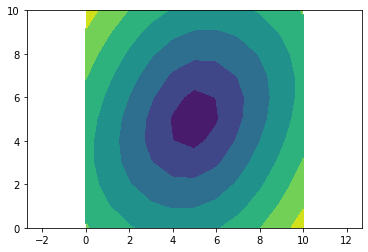

In [23]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,:,5]);

In [ ]:
norm_infinity(hfmOut['values'] - metric.norm(X))

In [ ]:
values = hfmOut['values']

In [ ]:
norm_infinity(values - hfmOut['values'])

In [ ]:
bTest=True

In [ ]:
bTest |= True

In [ ]:
bTest

In [24]:
metric.is_TTI()

True

In [27]:
Hooke.from_Reduced_VTI_to_Hooke(metric)